In [1]:
import pandas as pd

#google cloud big query libaries
from google.cloud import bigquery
from google.oauth2 import service_account

import os

In [2]:
dirShiny = "E:/GitHub/Resources/R-Shiny/HTS-Trip-Lengths/input"

group_by_columns = ['countyGroup','num_workers','num_vehicles','trip_type','mode_type_broad','binSize']
display(group_by_columns)

index_columns = group_by_columns + ['binStart']
display(index_columns)

# these columns, want to add a value that is the total of all values in column
agg_columns_to_all = ['num_workers','num_vehicles','trip_type','mode_type_broad']
display(agg_columns_to_all)

['countyGroup',
 'num_workers',
 'num_vehicles',
 'trip_type',
 'mode_type_broad',
 'binSize']

['countyGroup',
 'num_workers',
 'num_vehicles',
 'trip_type',
 'mode_type_broad',
 'binSize',
 'binStart']

['num_workers', 'num_vehicles', 'trip_type', 'mode_type_broad']

# Setup Data

In [3]:
# Link to BigQuery Client through API

key_path = r"C:\Users\bhereth\confidential-2023-utah-hts-db5335615978.json"
#key_path = r"C:\Users\bhereth\tdm-scenarios-a85044dbbfd3.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)
print ('Successfully Linked to BigQuery Client!')

Successfully Linked to BigQuery Client!


In [4]:
str_sql = """
SELECT
  bins.countyGroup,
  bins.binSize,
  bins.binStart,
  hh.num_workers,
  hh.num_vehicles,
  trip.trip_type,
  trip.mode_type_broad,
  COUNT(*) as numRecords,
  SUM(trip.trip_weight) as totalTripWeight,
FROM
  `confidential-2023-utah-hts.20230313._q4-countyGroupsAndDistanceBins` as bins,
  `confidential-2023-utah-hts.20230313.hh` as hh,
  `confidential-2023-utah-hts.20230313.trip` as trip
WHERE
  trip.distance_miles >= bins.binStart
  AND
  trip.distance_miles < bins.binStart + bins.binSize
  AND
  trip.o_county = bins.county
  AND
  hh.hh_id = trip.hh_id
GROUP BY 
  bins.countyGroup,
  bins.binSize,
  bins.binStart,
  hh.num_workers,
  hh.num_vehicles,
  trip.trip_type,
  trip.mode_type_broad
"""

In [5]:
# test connection
df_trips_by_county_and_distance_bins = client.query(str_sql).to_dataframe()

display(df_trips_by_county_and_distance_bins)

,countyGroup,binSize,binStart,num_workers,num_vehicles,trip_type,mode_type_broad,numRecords,totalTripWeight
0,WeDaSLUt,0.5,2.0,1,1,6,3,218,9736.642919
1,49035,0.5,2.0,1,1,6,3,103,5248.454926
2,WeDaSLUt,1.0,2.0,1,1,6,3,401,19423.204716
3,49035,1.0,2.0,1,1,6,3,212,11722.539814
4,WeDaSLUt,2.0,2.0,1,1,6,3,687,30607.071140
...,...,...,...,...,...,...,...,...,...
165757,49057,0.5,7.5,1,2,995,995,1,278.995501
165758,49049,0.5,10.0,3,2,995,995,4,0.000000
165759,49049,1.0,10.0,3,2,995,995,4,0.000000
165760,49049,2.0,10.0,3,2,995,995,4,0.000000


In [6]:
# check that index is unique

# Assuming df_trips_by_county_and_distance_bins is your DataFrame and index_columns is your list of columns

# Check if the combination of columns in index_columns forms a unique index
is_unique = not df_trips_by_county_and_distance_bins.duplicated(subset=index_columns).any()

# Print the result
print("Is the index unique?", is_unique)


Is the index unique? True


In [7]:
_df = df_trips_by_county_and_distance_bins.copy()

# Calculate the sum for these columns
sum_columns = ['totalTripWeight', 'numRecords']

# Loop through each column specified in calculate_total_columns
for col in agg_columns_to_all:
    print(col)
    # Determine columns to group by, excluding the current column in the loop
    group_without_agg_column = [c for c in _df.columns if c not in [col] + sum_columns]

    #display(group_without_agg_column)

    # Group by the remaining columns and calculate sums
    grouped_df = _df.groupby(group_without_agg_column, as_index=False).sum()
    grouped_df[col] = 'All'

    _df = pd.concat([_df, grouped_df], ignore_index=True)

    is_unique = not _df.duplicated(subset=index_columns).any()

    # Print the result
    print("Is the index unique?", is_unique)

# Identify remaining columns to group by that are not in sum_columns or agg_columns_to_all
remaining_group_columns = [col for col in _df.columns if col not in agg_columns_to_all + sum_columns]

# Group by these remaining columns to calculate the grand total
grand_totals_df = _df.groupby(remaining_group_columns, as_index=False).sum()[remaining_group_columns + sum_columns]

# Set the aggregated columns to 'All' in the grand totals row
for col in agg_columns_to_all:
    grand_totals_df[col] = 'All'

#display(grand_totals_df)

# Concatenate the grand total row to the results DataFrame
_df = pd.concat([_df, grand_totals_df], ignore_index=True)

display(_df)

df_trips_by_county_and_distance_bins_with_totals = _df



num_workers
Is the index unique? True
num_vehicles
Is the index unique? True
trip_type
Is the index unique? True
mode_type_broad
Is the index unique? True


,countyGroup,binSize,binStart,num_workers,num_vehicles,trip_type,mode_type_broad,numRecords,totalTripWeight
0,WeDaSLUt,0.5,2.0,1,1,6,3,218,9736.642919
1,49035,0.5,2.0,1,1,6,3,103,5248.454926
2,WeDaSLUt,1.0,2.0,1,1,6,3,401,19423.204716
3,49035,1.0,2.0,1,1,6,3,212,11722.539814
4,WeDaSLUt,2.0,2.0,1,1,6,3,687,30607.071140
...,...,...,...,...,...,...,...,...,...
724065,WeDaSLUt,5.0,80.0,All,All,All,All,2336,51026.634674
724066,WeDaSLUt,5.0,85.0,All,All,All,All,1584,33949.096439
724067,WeDaSLUt,5.0,90.0,All,All,All,All,1536,16868.975807
724068,WeDaSLUt,5.0,95.0,All,All,All,All,1088,9543.714576


In [8]:
# check that index is unique

# Assuming df_trips_by_county_and_distance_bins is your DataFrame and index_columns is your list of columns

# Check if the combination of columns in index_columns forms a unique index
is_unique = not df_trips_by_county_and_distance_bins_with_totals.duplicated().any()

# Print the result
print("Is the index unique?", is_unique)


Is the index unique? True


In [9]:
df_value_labels= client.query("SELECT * FROM `confidential-2023-utah-hts.20230313.value_labels`").to_dataframe()

display(df_value_labels)

,table,variable,value,label
0,person,age,8,55-64
1,person,age,1,Under 5
2,person,age,2,5-15
3,person,age,11,85 or older
4,person,age,3,16-17
...,...,...,...,...
2037,person,second_home_county,995,Missing response
2038,trip,trace_quality_flag,995,Missing response
2039,person,commute_subsidy_998,995,Missing response
2040,trip,trip_survey_complete,995,Missing response


In [10]:
def process_labels(variable, new_column_name):
    """
    Processes and formats a specific variable's labels from a DataFrame.

    Parameters:
    variable (str): The variable to filter and process.
    new_column_name (str): The new column name for the processed variable.

    Returns:
    DataFrame: A processed DataFrame with formatted labels for the specified variable.
    """
    # Filter the DataFrame for the specified variable
    df_labels = df_value_labels[df_value_labels['variable'] == variable].copy()
    
    # Assuming df_labels is your DataFrame and 'value' is initially not in integer format
    df_labels['value'] = df_labels['value'].astype(int)  # Convert 'value' to integer

    # Now sort the DataFrame by the 'value' column
    df_labels.sort_values(by='value', inplace=True)

    # Rename 'value' column to new_column_name and convert it to int64
    #df_labels.rename(columns={'value': variable}, inplace=True)

    #df_labels['newLabel'] = df_labels['value'].astype(str) + ': ' + df_labels['label']
    
    df_labels['newLabel'] = df_labels['label']

    # Drop unnecessary columns
    df_labels.drop(columns=['table', 'variable', 'label'], inplace=True)

    df_labels.rename(columns={'newLabel': 'label'}, inplace=True)

    
    df_labels = pd.concat([pd.DataFrame([['All','All']], columns=['value', 'label']),df_labels])

    display(df_labels)

    return df_labels

# Example usage:
# Assuming df_value_labels is a DataFrame you have that meets the requirements
df_trip_type_labels = process_labels('trip_type', 'Trip Type')
df_mode_type_broad_labels = process_labels('mode_type_broad', 'Broad Mode Type')
df_num_workers_labels = process_labels('num_workers', 'Number Worker')
df_num_vehicles_labels = process_labels('num_vehicles', 'Number Vehicle')

df_trip_type_labels.to_csv(os.path.join(dirShiny,'trip_type_labels.csv'), index=False)
df_mode_type_broad_labels.to_csv(os.path.join(dirShiny, 'mode_type_broad_labels.csv'), index=False)
df_num_workers_labels.to_csv(os.path.join(dirShiny, 'num_workers_labels.csv'), index=False)
df_num_vehicles_labels.to_csv(os.path.join(dirShiny, 'num_vehicles_labels.csv'), index=False)


,value,label
0,All,All
772,1,Home-based work
769,2,Home-based school
773,3,Home-based shopping
768,4,Home-based personal business
774,5,Home-based other
770,6,Non-home-based work
771,7,Non-home-based non-work
2003,995,Missing response


,value,label
0,All,All
1244,1,Walk
1245,2,Bike
1247,3,Car
1246,4,Transit
1546,5,Other
2030,995,Missing response


,value,label
0,All,All
908,0,0 (No workers)
911,1,1 worker
909,2,2 workers
917,3,3 workers
907,4,4 workers
918,5,5 workers
915,6,6 workers
912,7,7 workers
910,8,8 workers


,value,label
0,All,All
1050,0,0 (no vehicles in household)
1049,1,1 vehicle
1052,2,2 vehicles
1047,3,3 vehicles
1051,4,4 vehicles
1053,5,5 vehicles
1048,6,6 vehicles
1045,7,7 vehicles
1046,8,8 or more vehicles


In [11]:
df_county_groups = pd.DataFrame([
    ['WeDaSLUt','All Four WF Urban Counties'],
    ['49057','Weber'],
    ['49011','Davis'],
    ['49035','Salt Lake'],
    ['49049','Utah'],
], columns=['value','label'])
display(df_county_groups)

df_county_groups.to_csv(os.path.join(dirShiny, 'county_groups_labels.csv'), index=False)


,value,label
0,WeDaSLUt,All Four WF Urban Counties
1,49057,Weber
2,49011,Davis
3,49035,Salt Lake
4,49049,Utah


In [12]:
df_bin_sizes = df_trips_by_county_and_distance_bins_with_totals[['binSize']].drop_duplicates()
df_bin_sizes.columns = ['value']
df_bin_sizes.loc[df_bin_sizes['value']==0.5, 'label'] = "1/2-mile"
df_bin_sizes.loc[df_bin_sizes['value']>=1, 'label'] = df_bin_sizes['value'].astype(int).astype(str) + "-mile"

display(df_bin_sizes)
df_bin_sizes.to_csv(os.path.join(dirShiny, 'bin_sizes_labels.csv'), index=False)


,value,label
0,0.5,1/2-mile
2,1.0,1-mile
4,2.0,2-mile
6,3.0,3-mile
8,5.0,5-mile


# Calculate Distributions

In [13]:
# Group by 'trip_type' and 'distance_miles_2mibin' and sum 'trip_weight_sum'
grouped = df_trips_by_county_and_distance_bins_with_totals.groupby(index_columns).agg({'numRecords': 'sum', 'totalTripWeight': 'sum'}).reset_index()

# Calculate the total weight for each trip type
total_weights = grouped.groupby(group_by_columns)['totalTripWeight'].transform('sum')

# Calculate percentage distribution
grouped['percentage'] = (grouped['totalTripWeight'] / total_weights) * 100

# Add cumulative distribution

# Assuming 'filtered_grouped' is a DataFrame that has been grouped appropriately
grouped['cumulative_percentage'] = grouped.groupby(group_by_columns)['percentage'].cumsum()

grouped = grouped.fillna(0)

display(grouped)

,countyGroup,num_workers,num_vehicles,trip_type,mode_type_broad,binSize,binStart,numRecords,totalTripWeight,percentage,cumulative_percentage
0,49011,0,0,3,1,0.5,0.5,2,251.165173,100.000000,100.000000
1,49011,0,0,3,1,0.5,1.5,1,0.000000,0.000000,100.000000
2,49011,0,0,3,1,0.5,2.0,1,0.000000,0.000000,100.000000
3,49011,0,0,3,1,0.5,2.5,1,0.000000,0.000000,100.000000
4,49011,0,0,3,1,1.0,0.0,2,251.165173,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
722098,WeDaSLUt,All,All,All,All,5.0,80.0,2482,54215.799341,0.031453,99.922252
722099,WeDaSLUt,All,All,All,All,5.0,85.0,1683,36070.914967,0.020926,99.943178
722100,WeDaSLUt,All,All,All,All,5.0,90.0,1632,17923.286795,0.010398,99.953577
722101,WeDaSLUt,All,All,All,All,5.0,95.0,1156,10140.196737,0.005883,99.959459


In [14]:
grouped.to_csv(r'E:\GitHub\Resources\R-Shiny\HTS-Trip-Lengths\input\hts-trip-lengths.csv', index=False)

In [15]:
display(grouped)

,countyGroup,num_workers,num_vehicles,trip_type,mode_type_broad,binSize,binStart,numRecords,totalTripWeight,percentage,cumulative_percentage
0,49011,0,0,3,1,0.5,0.5,2,251.165173,100.000000,100.000000
1,49011,0,0,3,1,0.5,1.5,1,0.000000,0.000000,100.000000
2,49011,0,0,3,1,0.5,2.0,1,0.000000,0.000000,100.000000
3,49011,0,0,3,1,0.5,2.5,1,0.000000,0.000000,100.000000
4,49011,0,0,3,1,1.0,0.0,2,251.165173,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...
722098,WeDaSLUt,All,All,All,All,5.0,80.0,2482,54215.799341,0.031453,99.922252
722099,WeDaSLUt,All,All,All,All,5.0,85.0,1683,36070.914967,0.020926,99.943178
722100,WeDaSLUt,All,All,All,All,5.0,90.0,1632,17923.286795,0.010398,99.953577
722101,WeDaSLUt,All,All,All,All,5.0,95.0,1156,10140.196737,0.005883,99.959459


,countyGroup,num_workers,num_vehicles,trip_type,mode_type_broad,binSize,binStart,numRecords,totalTripWeight,percentage,cumulative_percentage
721695,WeDaSLUt,All,All,All,All,0.5,0.0,461873,1.406604e+07,8.163646,8.163646
721696,WeDaSLUt,All,All,All,All,0.5,0.5,543099,1.828494e+07,10.612209,18.775854
721697,WeDaSLUt,All,All,All,All,0.5,1.0,452846,1.536316e+07,8.916470,27.692325
721698,WeDaSLUt,All,All,All,All,0.5,1.5,379287,1.451881e+07,8.426425,36.118750
721699,WeDaSLUt,All,All,All,All,0.5,2.0,321929,1.242037e+07,7.208529,43.327279
...,...,...,...,...,...,...,...,...,...,...,...
721891,WeDaSLUt,All,All,All,All,0.5,98.0,102,1.201760e+02,0.000070,99.997615
721892,WeDaSLUt,All,All,All,All,0.5,98.5,68,1.295942e+03,0.000752,99.998367
721893,WeDaSLUt,All,All,All,All,0.5,99.0,136,1.661341e+03,0.000964,99.999331
721894,WeDaSLUt,All,All,All,All,0.5,99.5,102,1.151837e+03,0.000669,100.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


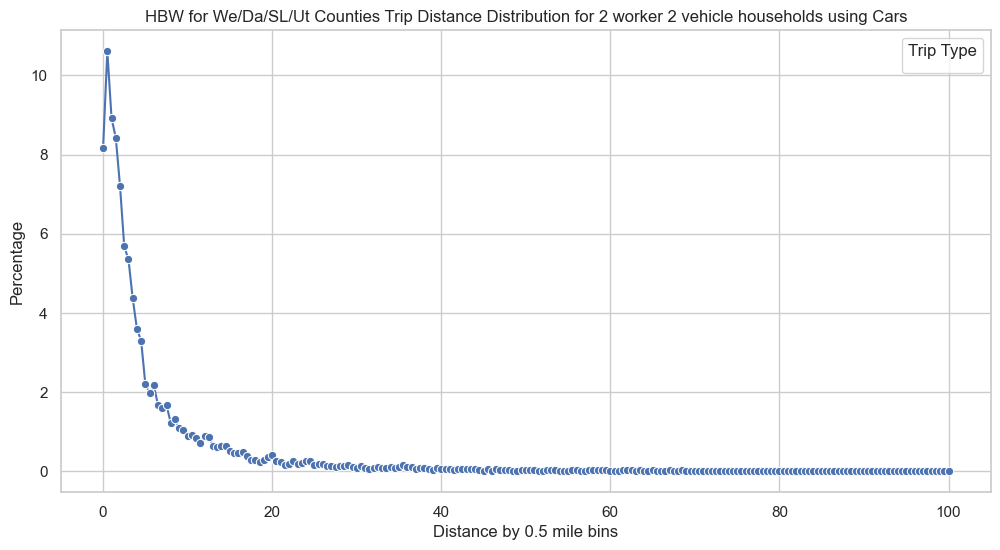

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style="whitegrid")

# filter
grouped_filtered = grouped[(grouped['countyGroup']=='WeDaSLUt') & 
                           (grouped['binSize']==0.5) & 
                           (grouped['num_workers']=='All') & 
                           (grouped['num_vehicles']=='All') & 
                           (grouped['trip_type']=='All') &
                           (grouped['mode_type_broad']=='All')
                           ]

display(grouped_filtered)

# Define a colorful palette
#palette = sns.color_palette("hsv", n_colors=grouped[group_by_columns].nunique())

# Create the line plot
plt.figure(figsize=(12, 6))
# Filter to only include bins up to 100 miles for visualization
line_plot = sns.lineplot(data=grouped_filtered, x='binStart', y='percentage',  marker='o')

# Set labels, title, and limits
plt.xlabel('Distance by 0.5 mile bins')
plt.ylabel('Percentage')
plt.title('HBW for We/Da/SL/Ut Counties Trip Distance Distribution for 2 worker 2 vehicle households using Cars')
plt.legend(title='Trip Type')

# Show the plot
plt.show()


,countyGroup,num_workers,num_vehicles,trip_type,mode_type_broad,binSize,binStart,numRecords,totalTripWeight,percentage,cumulative_percentage
563966,WeDaSLUt,2,2,1,3,0.5,0.0,73,1026.491808,0.507015,0.507015
563967,WeDaSLUt,2,2,1,3,0.5,0.5,182,6244.034312,3.084117,3.591132
563968,WeDaSLUt,2,2,1,3,0.5,1.0,220,5972.374684,2.949936,6.541068
563969,WeDaSLUt,2,2,1,3,0.5,1.5,252,9060.443304,4.475226,11.016295
563970,WeDaSLUt,2,2,1,3,0.5,2.0,213,11873.157482,5.864511,16.880806
...,...,...,...,...,...,...,...,...,...,...,...
564086,WeDaSLUt,2,2,1,3,0.5,73.0,1,0.000000,0.000000,99.980839
564087,WeDaSLUt,2,2,1,3,0.5,77.0,1,8.895524,0.004394,99.985233
564088,WeDaSLUt,2,2,1,3,0.5,86.0,1,29.896505,0.014767,100.000000
564089,WeDaSLUt,2,2,1,3,0.5,89.0,1,0.000000,0.000000,100.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


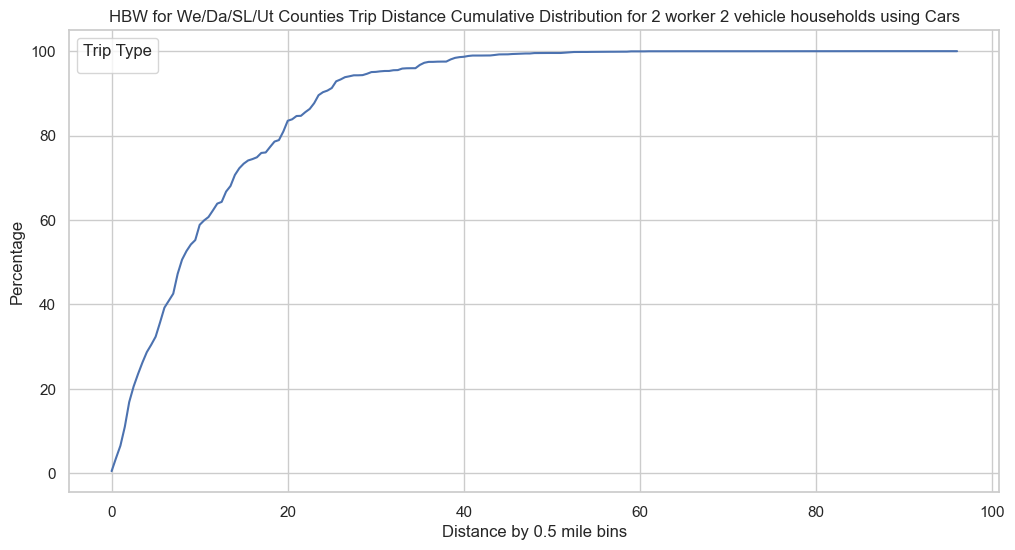

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style="whitegrid")

# filter
grouped_filtered = grouped[(grouped['countyGroup']=='WeDaSLUt') & 
                           (grouped['binSize']==0.5) & 
                           (grouped['num_workers']==2) & 
                           (grouped['num_vehicles']==2) & 
                           (grouped['trip_type']==1) &
                           (grouped['mode_type_broad']==3)
                           ]

display(grouped_filtered)

# Define a colorful palette
#palette = sns.color_palette("hsv", n_colors=grouped[group_by_columns].nunique())

# Create the line plot
plt.figure(figsize=(12, 6))
# Filter to only include bins up to 100 miles for visualization
line_plot = sns.lineplot(data=grouped_filtered, x='binStart', y='cumulative_percentage')

# Set labels, title, and limits
plt.xlabel('Distance by 0.5 mile bins')
plt.ylabel('Percentage')
plt.title('HBW for We/Da/SL/Ut Counties Trip Distance Cumulative Distribution for 2 worker 2 vehicle households using Cars')
plt.legend(title='Trip Type')

# Show the plot
plt.show()
